In [1]:
import tensorflow as tf
import PIL.Image
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import functools
import IPython.display as display

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams["axes.grid"] = False

In [4]:
def tensor_to_image(tensor):
    tensor = tensor*225
    tensor = np.array(tensor, dtype = np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [5]:
def load_img(path_to_image):
    max_dims = 512
    img = tf.io.read_file(path_to_image)
    img = tf.image.decode_image(img, channels = 3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dims/long_dim
    
    new_shape = tf.cast(shape*scale, tf.int32)
    
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [6]:
def img_show(image, title = None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis = 0)
        
    plt.imshow(image)
    if title:
        plt.title(title)

In [7]:
content_path = "D:/DANTHEPLAN/Style Transfer/Buntu.jpg"

In [ ]:
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [8]:
style_pic = "D:/DANTHEPLAN/Style Transfer/picasso2.jpg"
style_piet = "D:/DANTHEPLAN/Style Transfer/piet.jpg"
style_mon = "D:/DANTHEPLAN/Style Transfer/monet.jpg"
style_fri = "D:/DANTHEPLAN/Style Transfer/frida.jpg"

In [9]:
content_img = load_img(content_path)

In [34]:
content_img = load_img("C:/Users/Gaurav Rai/Buntu.jpg")

In [10]:
style_img = load_img(style_fri)

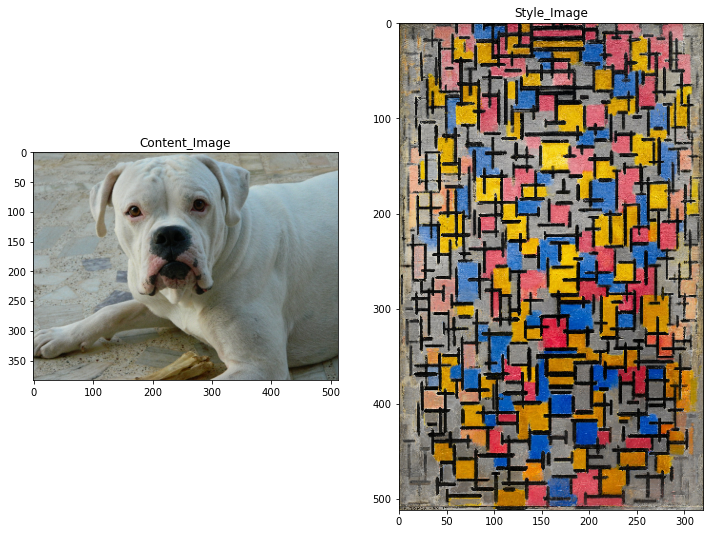

In [52]:
plt.subplot(1, 2, 1)
img_show(content_img, 'Content_Image')

plt.subplot(1, 2, 2)
img_show(style_img, 'Style_Image')

In [8]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)


input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [9]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [10]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
  
    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [ ]:
style_extractor = vgg_layers(style_layers)

In [ ]:
style_outputs = style_extractor(style_img*255)

In [11]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [12]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}
    
        return {'content':content_dict, 'style':style_dict}

In [19]:
extractor = StyleContentModel(style_layers, content_layers)

In [40]:
extractor2 = StyleContentModel(style_layers, content_layers)

In [20]:
results = extractor(tf.constant(content_img))

In [ ]:
results

In [41]:
style_targets = extractor2(style_img)['style']
content_targets = extractor2(content_img)['content']

In [42]:
image = tf.Variable(content_img)

In [13]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [14]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [15]:
style_weight=1e-2
content_weight=1e4

In [16]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [20]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor2(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

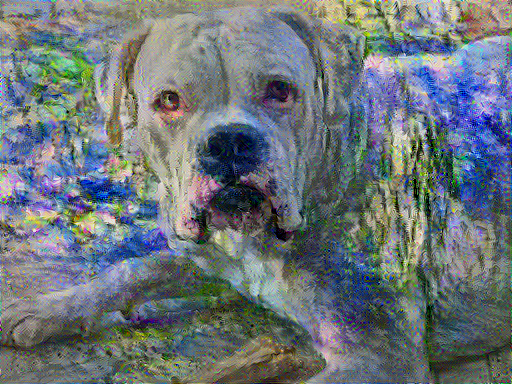

Train step: 5000
Total time: 646.5


In [28]:
import time
start = time.time()

epochs = 50
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

In [29]:
style_img = load_img(style_piet)

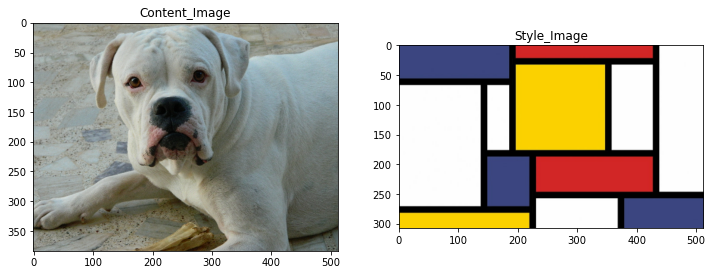

In [30]:
plt.subplot(1, 2, 1)
img_show(content_img, 'Content_Image')

plt.subplot(1, 2, 2)
img_show(style_img, 'Style_Image')

In [31]:
style_targets = extractor(style_img)['style']
content_targets = extractor(content_img)['content']

In [32]:
image2 = tf.Variable(content_img)

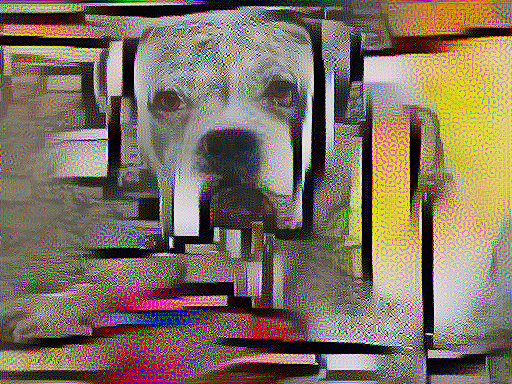

Train step: 5000
Total time: 667.2


In [48]:
import time
start = time.time()

epochs = 50
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image2)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image2))
    print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

In [53]:
extractor3 = StyleContentModel(style_layers, content_layers)

In [54]:
style_targets = extractor3(style_img)['style']
content_targets = extractor3(content_img)['content']

In [56]:
image3 = tf.Variable(content_img)

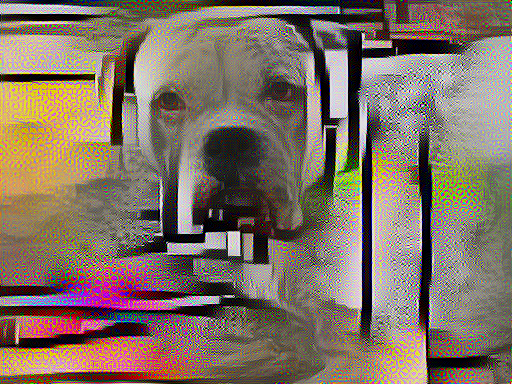

Train step: 5000
Total time: 639.8


In [57]:
import time
start = time.time()

epochs = 50
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image3)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image3))
    print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

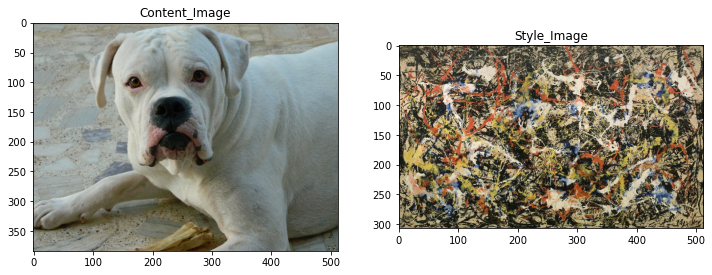

In [18]:
content_path = "D:/DANTHEPLAN/Style Transfer/Buntu.jpg"
style_jp = "D:/DANTHEPLAN/Style Transfer/JP.jpg"

content_img = load_img(content_path)
style_img = load_img(style_jp)

plt.subplot(1, 2, 1)
img_show(content_img, 'Content_Image')

plt.subplot(1, 2, 2)
img_show(style_img, 'Style_Image')

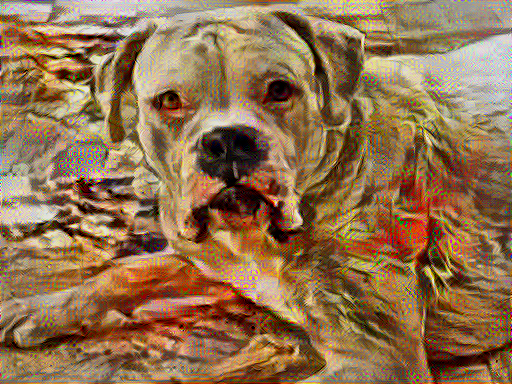

Train step: 5000
Total time: 762.5


In [23]:
extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_img)['style']
content_targets = extractor(content_img)['content']
image = tf.Variable(content_img)
import time
start = time.time()

epochs = 50
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))
    
end = time.time()
print("Total time: {:.1f}".format(end-start))

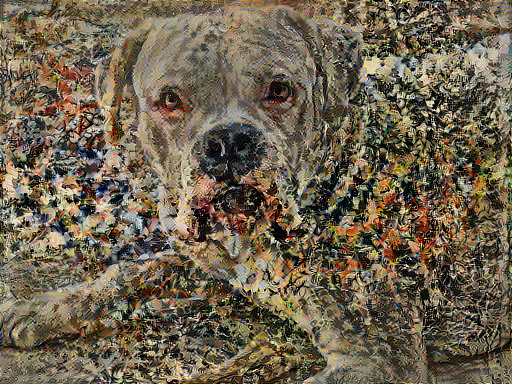

Train step: 5000
Total time: 1798.4


In [21]:
extractor2 = StyleContentModel(style_layers, content_layers)
style_targets = extractor2(style_img)['style']
content_targets = extractor2(content_img)['content']
image2 = tf.Variable(content_img)


start = time.time()

epochs = 50
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image2)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image2))
    print("Train step: {}".format(step))
    
end = time.time()
print("Total time: {:.1f}".format(end-start))